In [5]:
import pandas as pd
import os

# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'filtered_data.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

,note_id,person_id,age,gender_source_value,BMI,admission_department,division,ward,asa_class,surgeon_id,...,condition_source_value,surgery_room,previous_surgery,emergency_status,op_timing,day_of_the_week,week_of_the_month,month,surgeon_estimated_op_time,surgery_duration
0,101058,29,81,F,25.247087,General Surgery,Admission,NUGW2,2,9885,...,D00002196,203,N,N,TF2,Thursday,4,October,130,66
1,57801,64,60,F,24.376249,Otolaryngology,Admission,102,2,6194,...,D00003798,504,N,N,8A,Friday,2,January,300,130
2,71288,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF4,Monday,4,April,100,85
3,135104,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF2,Monday,3,August,100,83
4,221210,71,94,M,27.963140,Orthopedics,Admission,41,2,29473,...,D00018711,108,N,N,TF4,Monday,5,March,100,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161214,297111,4055249,1,M,23.700428,Pediatric Surgery,Admission,5A,1,100613,...,D00011688,5,N,Y,etc,Tuesday,2,September,200,123
161215,297455,4055328,1,M,20.612160,Pediatric Urology,Day,PDSC,1,6259,...,D00016707,7,N,N,8A,Monday,4,September,130,45
161216,297761,4055407,1,M,12.502703,Pediatric Surgery,Admission,5A,2,105057,...,D00011524,5,N,N,8A,Wednesday,3,September,130,43
161217,297753,4055558,4,F,14.365794,Pediatric Surgery,Admission,5A,2,105057,...,D00004831,5,N,N,TF6,Wednesday,3,September,130,82


In [6]:
from sklearn.model_selection import train_test_split

# Removing unnecessary columns
df.drop(columns=['note_id', 'person_id', 'surgeon_estimated_op_time', 'final_op_name'], inplace=True)

# Encoding binary columns
binary_cols = ['condition_source_value', 'op_code', 'surgeon_id', 'ward', 'admission_department', 'surgery_room']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding for other categorical columns
one_hot_cols = ['surgical_department', 'op_timing', 'month', 'anesthesia_type', 
                'day_of_the_week', 'asa_class', 'week_of_the_month', 
                'division', 'previous_surgery', 'emergency_status', 'gender_source_value']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Splitting the data
X_all = df_encoded.drop("surgery_duration", axis=1)
y_all = df_encoded["surgery_duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all
y_train_all


61344     122
137241     48
139478     76
113549     36
149411    127
         ... 
119879     76
103694     57
131932    311
146867     82
121958     57
Name: surgery_duration, Length: 128975, dtype: int64

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# 분과별 데이터셋 준비
departments = df['surgical_department'].unique()
models = {}
predictions = {}

# 각 분과별 모델 훈련
for dept in departments:
    # 열 이름 조정
    dept_col_name = 'surgical_department_' + dept

    # 분과별 데이터 필터링
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery_duration', axis=1)
    y_dept = dept_data['surgery_duration']

    # 데이터 분할
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # 모델 훈련 (랜덤 포레스트 예시)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_dept, y_train_dept)
    models[dept] = model

    # 테스트 데이터셋에 대한 예측 수행
    predictions[dept] = model.predict(X_test_dept)

# 앙상블을 위한 준비
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# 각 분과별 모델을 전체 테스트 데이터셋에 적용
for dept, model in models.items():
    # 열 이름 조정
    dept_col_name = 'surgical_department_' + dept

    # 해당 분과에 해당하는 테스트 데이터 인덱스
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # 해당 분과의 예측값 계산
    dept_predictions = model.predict(X_test_all.loc[dept_indices])

    # 최종 예측 배열에 해당 부분 업데이트
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# 성능 평가
mae = mean_absolute_error(y_test_all, final_predictions)
rmse = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2 = r2_score(y_test_all, final_predictions)

print(f"Ensemble MAE: {mae}, RMSE: {rmse}, R²: {r2}")

Ensemble MAE: 16.67870301451433, RMSE: 31.662393537060968, R²: 0.9158268414503081


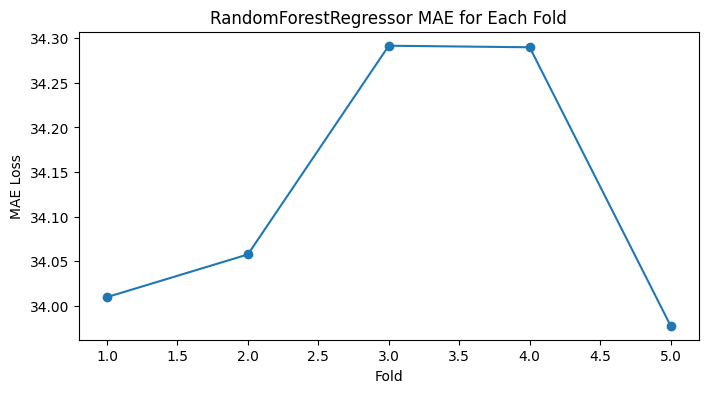

34.12521776250484

In [9]:
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt

# Setting up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for MAE of each fold
mae_scores = []

# Performing cross-validation
for train_index, test_index in kf.split(X_all):
    X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    y_train, y_test = y_all.iloc[train_index], y_all.iloc[test_index]

    # Training the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predictions and calculating MAE
    predictions = model.predict(X_test)
    fold_mae = mean_absolute_error(y_test, predictions)
    mae_scores.append(fold_mae)

# Plotting the MAE for each fold
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(1, len(mae_scores) + 1), mae_scores, marker='o')
ax.set_xlabel('Fold')
ax.set_ylabel('MAE Loss')
ax.set_title('RandomForestRegressor MAE for Each Fold')
plt.show()

# Average MAE across folds
average_mae = np.mean(mae_scores)
average_mae


In [10]:
from sklearn.model_selection import cross_val_score

# Setting up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for cross-validation results
cv_results = {}

# Performing cross-validation for each department
for dept in departments:
    dept_col_name = 'surgical_department_' + dept
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery_duration', axis=1)
    y_dept = dept_data['surgery_duration']

    # Training RandomForestRegressor model with cross-validation
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Calculating MAE for each fold
    mae_scores = -cross_val_score(model, X_dept, y_dept, cv=kf, scoring='neg_mean_absolute_error')
    
    # Storing the results
    cv_results[dept] = mae_scores

# Displaying the cross-validation MAE results for each department
cv_results


{'General Surgery': array([36.1838703 , 36.59642248, 36.39320001, 36.63163307, 36.39221169]),
 'Otolaryngology': array([45.62419958, 42.51285775, 44.67912489, 45.29652931, 44.92204333]),
 'Orthopedics': array([35.18120337, 33.88641697, 34.08216672, 34.72752934, 33.93806801]),
 'Ophthalmology': array([13.17717603, 13.60231365, 13.15336966, 13.37460281, 13.35545455]),
 'Obstetrics & Gynecology': array([34.92879235, 34.85044744, 34.77591659, 35.61297133, 34.61435708]),
 'Urology': array([24.42455865, 24.25231162, 23.06250785, 23.81907771, 24.52624019]),
 'Plastic Surgery': array([41.40099291, 39.22915485, 41.0888948 , 40.56588652, 41.14609929]),
 'Neurosurgery': array([51.1755007 , 52.34290682, 52.54899095, 50.06022965, 53.86899095]),
 'Cardiovascular Thoracic Surgery': array([49.26619583, 46.7560439 , 48.06033726, 48.63495717, 49.70142398]),
 'Pediatric Otolaryngology': array([23.12767563, 22.91758023, 23.30547268, 23.62209887, 22.67793403]),
 'Pediatric Orthopedics': array([49.38003841,

Trained with 10 trees: Train MAE = 14.218168637332818, Validation MAE = 35.618328991440265
Trained with 20 trees: Train MAE = 13.431035084318665, Validation MAE = 34.83335271678452
Trained with 30 trees: Train MAE = 13.107409730567941, Validation MAE = 34.521121810776165
Trained with 40 trees: Train MAE = 12.954999773857983, Validation MAE = 34.33141479810197
Trained with 50 trees: Train MAE = 12.871241997803192, Validation MAE = 34.264739269321424
Trained with 60 trees: Train MAE = 12.811511425556203, Validation MAE = 34.210261418144974
Trained with 70 trees: Train MAE = 12.769830015045367, Validation MAE = 34.13988290180234
Trained with 80 trees: Train MAE = 12.73590868708406, Validation MAE = 34.10936914619774
Trained with 90 trees: Train MAE = 12.699593403832209, Validation MAE = 34.06721626073412
Trained with 100 trees: Train MAE = 12.669679188473216, Validation MAE = 34.04604403920109


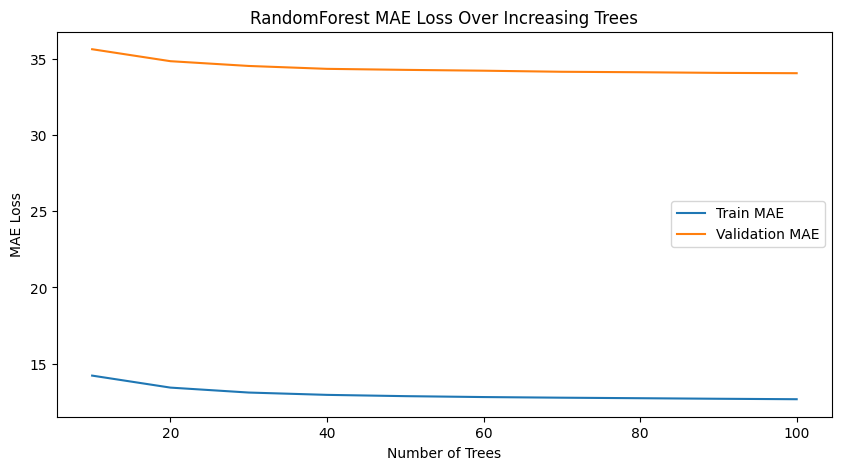

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Settings for demonstration
DEBUG = False  # Set to True for a quicker, less detailed run
n_estimators_step = 10  # Step size for increasing n_estimators
max_estimators = 100 #if DEBUG else 1500  # Max number of trees
train_mae = []
val_mae = []

# Iterative training of RandomForest
for n_trees in range(n_estimators_step, max_estimators + 1, n_estimators_step):
    clf = RandomForestRegressor(n_estimators=n_trees, random_state=42)
    
    # Training the model
    clf.fit(X_train_all, y_train_all)
    
    # Evaluating on training set
    train_predictions = clf.predict(X_train_all)
    train_mae.append(mean_absolute_error(y_train_all, train_predictions))
    
    # Evaluating on validation set
    val_predictions = clf.predict(X_test_all)
    val_mae.append(mean_absolute_error(y_test_all, val_predictions))

    # Verbose output
    print(f"Trained with {n_trees} trees: Train MAE = {train_mae[-1]}, Validation MAE = {val_mae[-1]}")

    # Early stopping criterion (optional)
    # if len(val_mae) > 2 and val_mae[-1] > val_mae[-2]:
    #     break

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(range(n_estimators_step, n_estimators_step * len(train_mae) + 1, n_estimators_step), train_mae, label='Train MAE')
plt.plot(range(n_estimators_step, n_estimators_step * len(val_mae) + 1, n_estimators_step), val_mae, label='Validation MAE')
plt.xlabel('Number of Trees')
plt.ylabel('MAE Loss')
plt.title('RandomForest MAE Loss Over Increasing Trees')
plt.legend()
plt.show()


In [13]:
from sklearn.model_selection import train_test_split

# 가정: df_encoded, df 및 기타 필요한 데이터가 이미 로드되어 있음

# 분과별 데이터셋 준비
departments = df['surgical_department'].unique()

# 분과별 모델 훈련 및 검증 결과 저장을 위한 딕셔너리
dept_train_mae = {}
dept_val_mae = {}

# 설정
n_estimators_step = 10
max_estimators = 100  # 예시를 위해 낮은 값 사용

# 각 분과별 모델 훈련
for dept in departments:
    # 열 이름 조정
    dept_col_name = 'surgical_department_' + dept

    # 분과별 데이터 필터링
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery_duration', axis=1)
    y_dept = dept_data['surgery_duration']

    # 데이터 분할
    X_train_dept, X_val_dept, y_train_dept, y_val_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # 각 분과별 MAE 저장을 위한 리스트
    train_mae = []
    val_mae = []

    # 나무 수 증가에 따른 반복 학습
    for n_trees in range(n_estimators_step, max_estimators + 1, n_estimators_step):
        model = RandomForestRegressor(n_estimators=n_trees, random_state=42)
        model.fit(X_train_dept, y_train_dept)

        # 훈련 및 검증 세트에 대한 MAE 계산
        train_mae.append(mean_absolute_error(y_train_dept, model.predict(X_train_dept)))
        val_mae.append(mean_absolute_error(y_val_dept, model.predict(X_val_dept)))

    # 결과 저장
    dept_train_mae[dept] = train_mae
    dept_val_mae[dept] = val_mae

# 각 분과별 MAE 성능 시각화
plt.figure(figsize=(15, 8))

for dept in departments:
    if dept in dept_train_mae:
        plt.plot(range(n_estimators_step, max_estimators + 1, n_estimators_step), dept_val_mae[dept], label=f'{dept} Validation MAE')

plt.xlabel('Number of Trees')
plt.ylabel('MAE Loss')
plt.title('Validation MAE Loss Across Different Departments')
plt.legend()
plt.show()
